Решим задачу классификации на набор MNIST. Набор данных MNIST - Mixed National Institute Of Standars and Technology - смешанный набор данных института, который содерит около 70 00 изображений цифр, написанных от руки учащимися.

In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

In [2]:
mnist = fetch_openml("mnist_784", as_frame=False)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
mnist["data"]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [5]:
mnist["target"]

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [6]:
mnist["data"].shape

(70000, 784)

DESCR - описание набор данных  
data - массив 0 и 1, это bitmap изображения, которое эквивалентно цифре в target
target - метки, то на какую цифру похоже изображение

In [7]:
def plot_digit(image_data):
  image = image_data.reshape(28, 28)
  plt.imshow(image, cmap='binary')
  plt.axis("off")

In [8]:
some_digit = 50

3


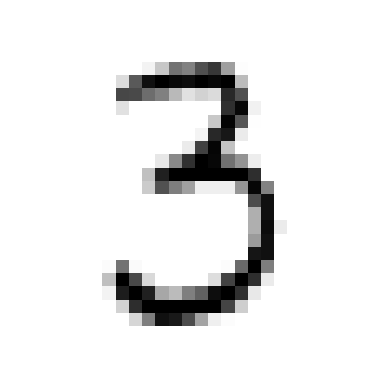

In [9]:
plot_digit(mnist["data"][some_digit])
print(mnist["target"][some_digit])

Создадим набор меток и набор даты

In [10]:
X, y= mnist.data, mnist.target

In [11]:
some_digit = X[50]

Конвертируем target из строкового представления в цифровое

In [12]:
y = y.astype(np.uint8)

Тестовый и тренировочный набор

In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Создадим самый простой классификатор - двоичный классификатор(бинарный). Построим его для 5.

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Создадим модель на основе SGD (Stochastic Gradient Descent)

In [15]:
sgd = SGDClassifier(random_state=42)
sgd.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [16]:
sgd.predict([X_train[0]])

array([ True])

In [17]:
cross_val_score(sgd, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [18]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train_5)

DummyClassifier()

In [19]:
cross_val_score(dummy, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

Confusion Matrix - Матрица нетодчностей

Матрица неточностей состоит из 4 метрик и имеет размер 2 на 2.

In [20]:
y_train_predict = cross_val_predict(sgd, X_train, y_train_5, cv=3)

In [21]:
cm = confusion_matrix(y_train_5, y_train_predict)

In [22]:
cm

array([[53892,   687],
       [ 1891,  3530]])

In [23]:
y_train_perfect = y_train_5
confusion_matrix(y_train_5, y_train_perfect)

array([[54579,     0],
       [    0,  5421]])

Посчитаем руками precision

In [24]:
cm[1,1] / (cm[1,1] + cm[0,1])

np.float64(0.8370879772350012)

Посчитаем в scilearn

In [25]:
precision_score(y_train_5, y_train_predict)

np.float64(0.8370879772350012)

Посчитаем руками recall

In [26]:
cm[1,1] / (cm[1,0] + cm[1,1])

np.float64(0.6511713705958311)

Посчитаем scilearn

In [27]:
recall_score(y_train_5, y_train_predict)

np.float64(0.6511713705958311)

Посчитаем F1 руками

In [28]:
cm[1,1] / (cm[1,1] + (cm[1,0] + cm[0,1])/2)

np.float64(0.7325171197343847)

Посчитаем scilearn

In [29]:
f1_score(y_train_5, y_train_predict)

np.float64(0.7325171197343847)

In [30]:
y_scores = sgd.decision_function([X[0]])
y_scores

array([2164.22030239])

Установим порог принятия решения в 3000.

In [31]:
threshold = 3000
y_digit_pred = (y_scores > threshold)

In [32]:
y_digit_pred

array([False])

Определим порог принятия графическим способом с помощью recall curve

In [33]:
y_scores = cross_val_predict(sgd, X_train, y_train_5, cv=3, method="decision_function")

In [34]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

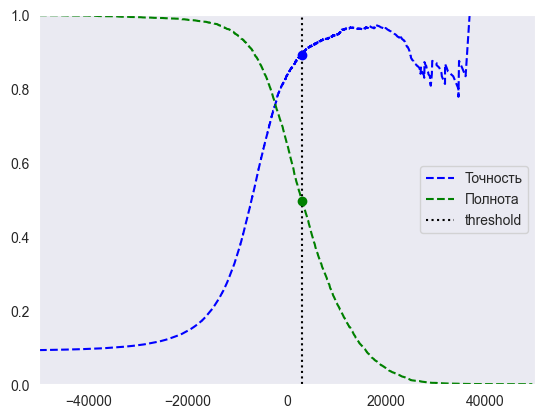

In [35]:
plt.plot(thresholds, precisions[:-1], "b--", label="Точность")
plt.plot(thresholds,  recalls[:-1], "g--", label="Полнота")
plt.vlines(threshold, 0, 1, "k", "dotted", label="threshold")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.legend(loc="center right")

idx = (thresholds >= threshold).argmax()
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.show()

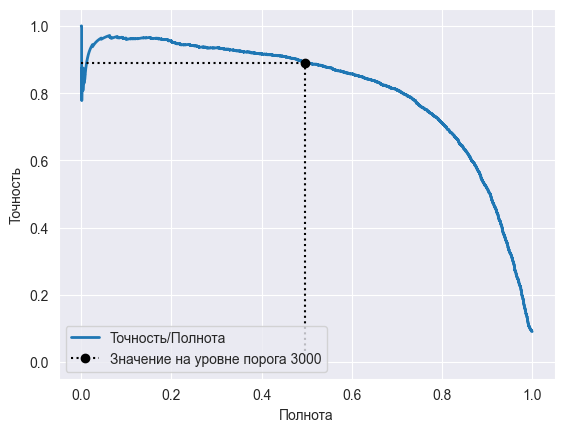

In [36]:
idx = (thresholds >= threshold).argmax()
plt.plot(recalls, precisions, linewidth=2, label="Точность/Полнота")
plt.plot([recalls[idx], recalls[idx]], [0,precisions[idx]], "k:")
plt.plot([0,recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko:", label="Значение на уровне порога 3000")
plt.xlabel("Полнота")
plt.ylabel("Точность")
plt.legend(loc="lower left")
plt.show()

In [37]:
threshold_for_90Precision = thresholds[(np.argmax(precisions >=0.90))]

In [38]:
threshold_for_90Precision

np.float64(3370.0194991439557)

In [39]:
y_train_pred_90 = (y_scores >= threshold_for_90Precision)

In [40]:
precision_score(y_train_5, y_train_pred_90)

np.float64(0.9000345901072293)

In [41]:
recall_score(y_train_5, y_train_pred_90)

np.float64(0.4799852425751706)

#ROC кривая![Logistic-curve.png](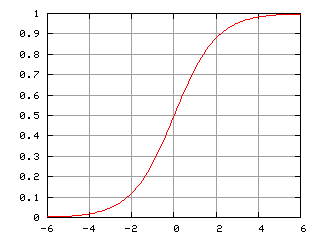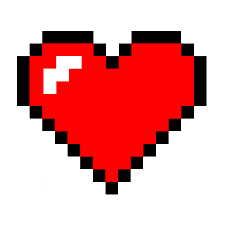)

roc curve - receiver operaiting characteristic это инструмент используемые для двоичных классификаторов. Roc кривая похожа на PR(precision-recall) кривую, однако имеет преимущество в виде возможности долю истинно положительных классификаций по отношениею к доле ложноположительных классификаций.

Таким образом ROC кривая отображает чувствительность(sensitivity) т.е. полноту в сравнении с 1 - specificity. Специфичность это доля истинно отрицательных классификация, которая получается как 1 - доля ложноположительных классификаций.

In [42]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

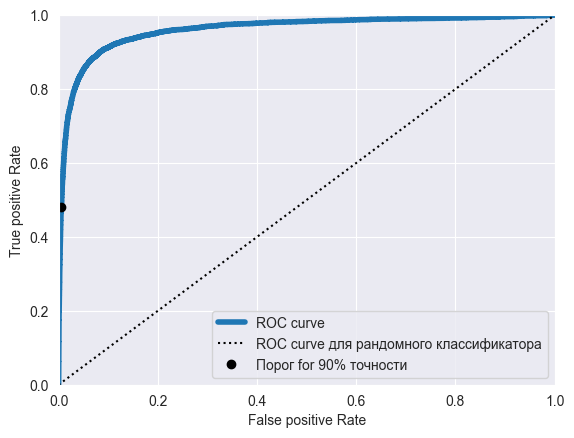

In [43]:
idx = (thresholds <= threshold_for_90Precision).argmax()
tpr_90, fpr_90 = tpr[idx], fpr[idx]
plt.plot(fpr, tpr, linewidth=4, label="ROC curve")
plt.plot([0,1], [0,1], 'k:', label="ROC curve для рандомного классификатора")
plt.plot([fpr_90], [tpr_90], "ko", label="Порог for 90% точности")
plt.xlabel("False positive Rate")
plt.ylabel("True positive Rate")
plt.legend(loc="lower right")
plt.axis([0, 1, 0, 1])
plt.show()

In [44]:
roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

In [45]:
forest_cls = RandomForestClassifier(random_state=42)

predict_proba это готовые вероятности, которые основаны на функции потерь(loss function) - максимизированием вероятности, что все объекты в обучающе выборке классифицированы правильно, а вероятность это сигмоида на значением формулы.

Сигмоинда это функция похожая на букву S, которая активно используется в регрессиях и нейронных сетях.

https://ru.wikipedia.org/wiki/%D0%A1%D0%B8%D0%B3%D0%BC%D0%BE%D0%B8%D0%B4%D0%B0

In [46]:
y_prob_forest = cross_val_predict(forest_cls, X_train, y_train_5, cv=3, method="predict_proba")

In [47]:
y_scores_forest = y_prob_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

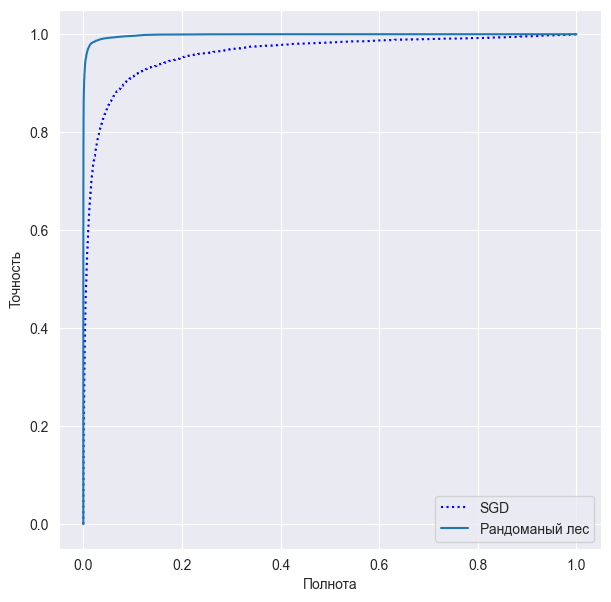

In [48]:
plt.figure(figsize=(7,7))
plt.plot(fpr,tpr, "b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, label="Рандоманый лес")
plt.xlabel("Полнота")
plt.ylabel("Точность")
plt.legend(loc="lower right")
plt.show()

In [49]:
roc_auc_score(y_train_5, y_scores_forest)


np.float64(0.9983436731328145)

In [50]:
recall_score(y_train_5, y_prob_forest[:, 1] >= 0.5) # positive_prob

np.float64(0.8725327430363402)

Для многоклассовой классификации используется системы множества бинарных классификаторов, которые работают по стратегии.  
OvA - One versus All стратегия Один против Всех.  
OVR - One versus Rest стратегия Один против Остальных.   
  
Вторым вариантом является стратегия, которыя будет обучать двоичные классификаторы для каждой пары цифр. Раличие 0 и 1, различие 0 и 2 и т.д. Это стратегия называется OvA One versus One - стратегия Один против Одного.

In [51]:
svc_cls = SVC(random_state=42)

In [52]:
svc_cls.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [53]:
svc_cls.predict([some_digit])

array([3], dtype=uint8)

In [54]:
some_digit_scores = svc_cls.decision_function([some_digit])
some_digit_scores.round(2)

array([[7.13, 3.77, 6.12, 9.31, 0.72, 8.28, 2.77, 0.73, 4.84, 0.74]])

In [55]:
svc_cls.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [56]:
svc_cls.decision_function_shape = "ovo"
some_digit_scores_ovo = svc_cls.decision_function([some_digit])
some_digit_scores_ovo.round(2)

array([[ 0.27,  0.03, -1.13,  0.81, -0.86,  0.4 ,  0.53,  0.15,  0.42,
        -0.63, -1.09,  0.29, -0.65,  0.05,  0.44, -0.34,  0.  , -1.32,
         0.5 , -0.57,  0.39,  0.5 ,  0.21,  0.25,  1.36,  1.16,  1.27,
         1.26,  1.36,  1.44, -1.05, -0.48, -0.21, -0.58,  0.02,  0.86,
         0.94,  0.83,  1.03,  0.14, -0.14,  0.17, -0.38, -0.04,  0.18]])

In [57]:
ovr_cls = OneVsRestClassifier(SVC(random_state=42))
ovr_cls.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [58]:
ovr_cls.predict([some_digit])

array([3], dtype=uint8)

In [59]:
ovr_cls.decision_function([some_digit]).round(2)

array([[-1.35, -1.28, -1.38,  1.  , -1.67, -1.19, -1.64, -1.52, -1.82,
        -1.81]])